Классификатор для распознавания эмоции в аудиофайле.

1. Ознакомьтесь с датасетом образцов эмоциональной речи

    **Toronto emotional speech set (TESS)**:

    https://dataverse.scholarsportal.info/dataset.xhtml?persistentId=doi:10.5683/SP2/E8H2MF

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip

2. Разберите датасет;
3. Подготовьте и разделите данные на обучающие и тестовые;
4. Разработайте классификатор, показывающий на тесте точность распознавания эмоции не менее 98%;
5. Ознакомьтесь с другим датасетом похожего содержания

    **Surrey Audio-Visual Expressed Emotion (SAVEE)**:

    https://www.kaggle.com/ejlok1/surrey-audiovisual-expressed-emotion-savee

    Ссылка для загрузки данных: https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip

6. Прогоните обученный классификатор на файлах из датасета **SAVEE** по вашему выбору;
7. Сделайте выводы.

In [ ]:
# Массивы
import numpy as np

# Отрисовка графиков
import matplotlib.pyplot as plt

# Загрузка из google облака
import gdown

# Преобразование категориальных данных в one hot encoding
from tensorflow.keras.utils import to_categorical

# Работа с папками и файлами
import os
# Регулярные выражения
import re
# Утилиты работы со временем
import time

# Работа со случайными числами
import random

# Математические функции
import math

# Сохранение и загрузка структур данных Python
import pickle

# Параметризация аудио
import librosa

# Оптимизаторы для обучения моделей
from tensorflow.keras.optimizers import Adam, RMSprop

# Конструирование и загрузка моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model, load_model

# Основные слои
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM
from tensorflow.keras.layers import MaxPooling1D, AveragePooling1D, SpatialDropout1D

# Разбиение на обучающую и проверочную выборку
from sklearn.model_selection import train_test_split

# Кодирование категориальных меток, нормирование числовых данных
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Отключение предупреждений
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras import utils

import librosa.display                    # Визуализация аудио
import IPython.display as ipd             # Проигрывание аудио в colab

%matplotlib inline 

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/dataverse_files.zip', None, quiet=True)

'dataverse_files.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip  -qo dataverse_files.zip -d /content/dataverse_files

# Проверка выгруженных папок
!ls dataverse_files 

MANIFEST.TXT		OAF_reach_fear.wav	 YAF_jail_ps.wav
OAF_back_angry.wav	OAF_reach_happy.wav	 YAF_jail_sad.wav
OAF_back_disgust.wav	OAF_reach_neutral.wav	 YAF_jar_angry.wav
OAF_back_fear.wav	OAF_reach_ps.wav	 YAF_jar_disgust.wav
OAF_back_happy.wav	OAF_reach_sad.wav	 YAF_jar_fear.wav
OAF_back_neutral.wav	OAF_read_angry.wav	 YAF_jar_happy.wav
OAF_back_ps.wav		OAF_read_disgust.wav	 YAF_jar_neutral.wav
OAF_back_sad.wav	OAF_read_fear.wav	 YAF_jar_ps.wav
OAF_bar_angry.wav	OAF_read_happy.wav	 YAF_jar_sad.wav
OAF_bar_disgust.wav	OAF_read_neutral.wav	 YAF_join_angry.wav
OAF_bar_fear.wav	OAF_read_ps.wav		 YAF_join_disgust.wav
OAF_bar_happy.wav	OAF_read_sad.wav	 YAF_join_fear.wav
OAF_bar_neutral.wav	OAF_red_angry.wav	 YAF_join_happy.wav
OAF_bar_ps.wav		OAF_red_disgust.wav	 YAF_join_neutral.wav
OAF_bar_sad.wav		OAF_red_fear.wav	 YAF_join_ps.wav
OAF_base_angry.wav	OAF_red_happy.wav	 YAF_join_sad.wav
OAF_base_disgust.wav	OAF_red_neutral.wav	 YAF_judge_angry.wav
OAF_base_fear.wav	OAF_red_ps.wav		 YAF_jud

In [ ]:
# Ваше решение
ipd.display(ipd.Audio('/content/dataverse_files/OAF_jail_disgust.wav'))

In [ ]:
# Установка констант

FILE_DIR = '/content/dataverse_files'                     # Папка с файлами датасета
CLASS_LIST = ['angry', 'disgust', 'fear', 'happy', 'ps', 'sad', 'neutral']
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов
CLASS_FILES = 100                         # Общее количество файлов в каждом классе
FILE_INDEX_TRAIN_SPLIT = 360               # Количество файлов каждого класса на основной набор
VALIDATION_SPLIT = 0.1                    # Доля проверочной выборки в основном наборе
DURATION_SEC = 30                         # Анализируемая длительность аудиосигнала
N_FFT = 8192                              # Размер окна преобразования Фурье для расчета спектра
HOP_LENGTH = 512                          # Объем данных для расчета одного набора признаков

In [ ]:
Filenames = []

for classN in CLASS_LIST:
  ClassFilenames=[]
  print(classN)
  for file_name in os.listdir(FILE_DIR):
    #print(file_name,classN,file_name.find(classN))
    if file_name.find(classN)>=0:
        ClassFilenames.append(file_name)
  Filenames.append(ClassFilenames)


angry
disgust
fear
happy
neutral
ps
sad


In [ ]:
# Функция параметризации аудио
def get_features(y,                     # волновое представление сигнала
                 sr,                    # частота дискретизации сигнала y
                 n_fft=N_FFT,           # размер скользящего окна БПФ
                 hop_length=HOP_LENGTH  # шаг скользящего окна БПФ
                 ):
    # Вычисление различных параметров (признаков) аудио

    # Хромаграмма
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Мел-кепстральные коэффициенты
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Среднеквадратическая амплитуда
    rmse = librosa.feature.rms(y=y, hop_length=hop_length)
    # Спектральный центроид
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Ширина полосы частот
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Спектральный спад частоты
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    # Пересечения нуля
    zcr = librosa.feature.zero_crossing_rate(y, hop_length=hop_length)
    
    # Сборка признаков в общий список:
    # На один файл несколько векторов признаков, количество определяется
    # продолжительностью аудио и параметром hop_length в функциях расчета признаков
    features = {'rmse': rmse, 
                'spct': spec_cent, 
                'spbw': spec_bw,
                'roff': rolloff,
                'zcr' : zcr,
                'mfcc': mfcc,
                'stft': chroma_stft}

    return features

# Функция объединения признаков в набор векторов

def stack_features(feat  # словарь признаков, отдельные векторы по ключу каждого признака
                   ):
    features = None
    for v in feat.values():
        features = np.vstack((features, v)) if features is not None else v

    return features.T

# Функция формирования набора признаков и метки класса для аудиофайла

def get_feature_list_from_file(class_index,  # индекс класса файла song_name
                               song_name,    # имя аудиофайла
                               duration_sec  # длительность аудио в секундах
                               ):
    # Загрузка в y первых duration_sec секунд аудиосигнала
    y, sr = librosa.load(song_name, mono=True, duration=duration_sec)

    # Извлечение параметров из аудиосигнала
    features = get_features(y, sr)
    feature_set = stack_features(features)

    # Перевод номера класса в one hot encoding
    y_label = to_categorical(class_index, CLASS_COUNT)

    return feature_set, y_label

# Функция формирования подвыборки признаков и меток класса для одного файла

def process_file(class_index,  # индекс класса аудиофайла
                 file_name,   # индекс (порядковый номер) аудиофайла в папке класса
                 duration_sec  # длительность аудио в секундах
                 ):
    x_list = []
    y_list = []
    class_name = CLASS_LIST[class_index]

    # Извлечение имени произведения
    song_name = f'{FILE_DIR}/{file_name}'

    # Выборка признаков и метки класса для произведения
    feature_set, y_label = get_feature_list_from_file(class_index, 
                                                        song_name,
                                                        duration_sec)

    # Добавление данных в наборы
    for j in range(feature_set.shape[0]):
        x_list.append(feature_set[j])
        y_list.append(y_label)

    # Возврат имени файла и numpy-массивов призанков и меток класса
    return song_name, \
           np.array(x_list).astype('float32'), \
           np.array(y_list).astype('float32')



In [ ]:
_, file_x_data, file_y_data = process_file(0, Filenames[0][1],None)

In [ ]:
# Функция формирования набора данных из файлов всех классов по диапазону номеров файлов

def extract_data(file_index_start,          # начальный индекс аудиофайла
                 file_index_end,            # конечный индекс аудиофайла (не достигая)
                 duration_sec=None  # длительность аудио в секундах
                 ):

    # Списки для последовательностей входных данных и меток класса
    x_data = None
    y_data = None

    # Фиксация времени старта формирования выборки
    curr_time = time.time()

    # Для всех классов:
    for class_index in range(len(CLASS_LIST)):
        # Для всех файлов текущего класса из заданного диапазона номеров:
        for file_index in range(file_index_start, file_index_end):
            # Обработка одного файла и добавление данных к общим массивам
            _, file_x_data, file_y_data = process_file(class_index, Filenames[class_index][file_index], duration_sec)
            x_data = file_x_data if x_data is None else np.vstack([x_data, file_x_data])
            y_data = file_y_data if y_data is None else np.vstack([y_data, file_y_data])

        # Вывод информации о готовности обработки датасета
        print(f'Жанр {CLASS_LIST[class_index]} готов -> {round(time.time() - curr_time)} c')
        curr_time = time.time()

    # Возврат массивов набора данных
    return x_data, y_data

In [ ]:
# Формирование тренировочного (основного) набора данных
x_train_data, y_train_data = extract_data(0, FILE_INDEX_TRAIN_SPLIT)

Жанр angry готов -> 79 c
Жанр disgust готов -> 95 c
Жанр fear готов -> 76 c
Жанр happy готов -> 84 c
Жанр neutral готов -> 87 c
Жанр ps готов -> 86 c
Жанр sad готов -> 96 c


In [ ]:
# Формирование тренировочного (основного) набора данных
x_test_data, y_test_data = extract_data(FILE_INDEX_TRAIN_SPLIT,400)

Жанр angry готов -> 9 c
Жанр disgust готов -> 11 c
Жанр fear готов -> 8 c
Жанр happy готов -> 9 c
Жанр neutral готов -> 9 c
Жанр ps готов -> 9 c
Жанр sad готов -> 11 c


In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
# Сохранение/восстановление датасета аудио
# Данные привязаны к порядку следования меток классов!
# Порядок классов фиксирован сортировкой списка меток классов
with open('/content/drive/My Drive/NN/audio_data_train.pickle', 'wb') as f:
    pickle.dump((x_train_data, y_train_data), f)
with open('/content/drive/My Drive/NN/audio_data_test.pickle', 'wb') as f:
    pickle.dump((x_test_data, y_test_data), f)


In [ ]:
with open('/content/drive/My Drive/NN/audio_data_train.pickle', 'rb') as f:
    x_train_data, y_train_data = pickle.load(f)
with open('/content/drive/My Drive/NN/audio_data_test.pickle', 'rb') as f:
    x_test_data, y_test_data = pickle.load(f)

In [ ]:
# Вывод номеров классов для проверки правильности заполнения
# Номера классов идут последовательно крупными блоками
print(np.argmax(y_train_data, axis=1))

[0 0 0 ... 6 6 6]


In [ ]:
# Вывод формы данных обучающего набора
print(x_train_data.shape, x_train_data.dtype)
print(y_train_data.shape, y_train_data.dtype)

(224157, 37) float32
(224157, 7) float32


In [ ]:
# Нормирование признаков в соответствии со стандартным нормальным распределением
x_scaler = StandardScaler()
x_train_data_scaled = x_scaler.fit_transform(x_train_data)

In [ ]:
# Разделение набора данных на обучающую и проверочную выборки
# Параметр stratify указывает метки классов, по которым происходит балансировка разделения
x_train, x_val, y_train, y_val = train_test_split(x_train_data_scaled,
                                                  y_train_data,
                                                  stratify=y_train_data,
                                                  test_size=VALIDATION_SPLIT)

In [ ]:
# Проверка нормирования
print(x_train[0])

[-0.9146318  -0.82782245 -0.83581793 -0.6839231  -0.16931774 -0.30533478
  0.81544656  0.5310295   1.828585    0.986939   -0.20859022  0.46430507
 -0.17678683  0.54160297 -0.17182355  0.7976801   0.1890743  -0.00570272
  0.9784415   0.6661831   0.15727483  0.8900279   0.18298759  0.47711805
  0.04593579 -0.69256705 -0.3666019  -0.8326601  -0.85758764 -0.76204467
  0.3958572   1.9078164   0.04977057 -0.6472487  -0.7831997  -0.8218358
 -0.8490687 ]


In [ ]:
# Проверка формы и типа данных обучающей и проверочной выборок
print(x_train.shape, x_train.dtype)
print(y_train.shape, y_train.dtype)
print()
print(x_val.shape, x_val.dtype)
print(y_val.shape, y_val.dtype)

(201741, 37) float32
(201741, 7) float32

(22416, 37) float32
(22416, 7) float32


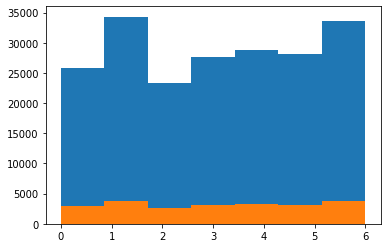

In [ ]:
# Проверка сбалансированности выборок по классам
plt.hist(np.argmax(y_train, axis=1), CLASS_COUNT)
plt.hist(np.argmax(y_val, axis=1), CLASS_COUNT)
plt.show()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               19456     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dense_9 (Dense)             (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                                 
 batch_normalization_7 (Batc  (None, 256)              1024      
 hNormalization)                                      

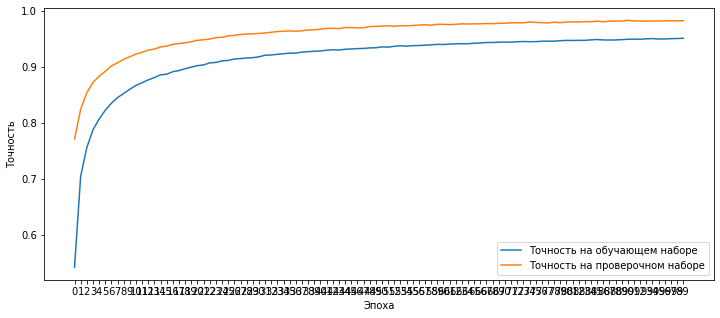

In [ ]:
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=x_train[0].shape))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Dense(CLASS_COUNT, activation='softmax'))

    # Компиляция модели
model.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()
# Обучение модели
history = model.fit(x_train,y_train,epochs=100,batch_size=128,validation_data=(x_val, y_val))

# Вывод графика точности распознавания на обучающей и проверочной выборках
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xticks(range(100))
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()

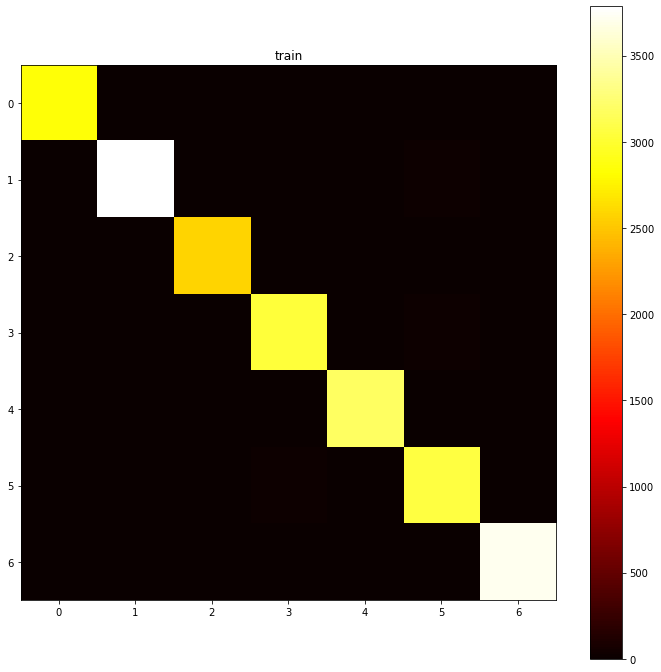

In [ ]:
y_prd=model.predict(x_val)
ClassMatrix=np.zeros((y_prd.shape[-1],y_prd.shape[-1]))
for i in range(y_prd.shape[0]):
  ClassMatrix[np.argmax(y_prd[i]),np.argmax(y_val[i])]+=1
plt.figure(figsize=(12,12))
plt.imshow(ClassMatrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('train')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [ ]:
model.save('/content/drive/My Drive/NN/model_emotion.h5')

In [ ]:
import keras
model=keras.models.load_model('/content/drive/My Drive/NN/model_emotion.h5')

In [ ]:
# Загрузка датасета из облака
gdown.download('https://storage.googleapis.com/datasets_ai/Base/12_audio/archive.zip', None, quiet=True)

'archive.zip'

In [ ]:
# Распаковка архива на локальный диск colab
!unzip  -qo archive.zip -d /content/12_audio_files 

In [ ]:
# Проверка выгруженных папок
!ls 12_audio_files/ALL/

DC_a01.wav  DC_n21.wav	 JE_f11.wav   JK_a01.wav  JK_n21.wav   KL_f11.wav
DC_a02.wav  DC_n22.wav	 JE_f12.wav   JK_a02.wav  JK_n22.wav   KL_f12.wav
DC_a03.wav  DC_n23.wav	 JE_f13.wav   JK_a03.wav  JK_n23.wav   KL_f13.wav
DC_a04.wav  DC_n24.wav	 JE_f14.wav   JK_a04.wav  JK_n24.wav   KL_f14.wav
DC_a05.wav  DC_n25.wav	 JE_f15.wav   JK_a05.wav  JK_n25.wav   KL_f15.wav
DC_a06.wav  DC_n26.wav	 JE_h01.wav   JK_a06.wav  JK_n26.wav   KL_h01.wav
DC_a07.wav  DC_n27.wav	 JE_h02.wav   JK_a07.wav  JK_n27.wav   KL_h02.wav
DC_a08.wav  DC_n28.wav	 JE_h03.wav   JK_a08.wav  JK_n28.wav   KL_h03.wav
DC_a09.wav  DC_n29.wav	 JE_h04.wav   JK_a09.wav  JK_n29.wav   KL_h04.wav
DC_a10.wav  DC_n30.wav	 JE_h05.wav   JK_a10.wav  JK_n30.wav   KL_h05.wav
DC_a11.wav  DC_sa01.wav  JE_h06.wav   JK_a11.wav  JK_sa01.wav  KL_h06.wav
DC_a12.wav  DC_sa02.wav  JE_h07.wav   JK_a12.wav  JK_sa02.wav  KL_h07.wav
DC_a13.wav  DC_sa03.wav  JE_h08.wav   JK_a13.wav  JK_sa03.wav  KL_h08.wav
DC_a14.wav  DC_sa04.wav  JE_h09.wav   JK_a14.wav

In [ ]:
# Ваше решение
ipd.display(ipd.Audio('12_audio_files/ALL/DC_a05.wav'))
ipd.display(ipd.Audio('12_audio_files/ALL/DC_d02.wav'))
ipd.display(ipd.Audio('12_audio_files/ALL/DC_f01.wav'))
ipd.display(ipd.Audio('12_audio_files/ALL/DC_h02.wav'))
ipd.display(ipd.Audio('12_audio_files/ALL/DC_n28.wav'))
ipd.display(ipd.Audio('12_audio_files/ALL/DC_sa04.wav'))
ipd.display(ipd.Audio('12_audio_files/ALL/DC_su10.wav'))

In [ ]:
# Установка констант

FILE_DIR = '/content/12_audio_files/ALL'                     # Папка с файлами датасета
CLASS_LIST = ['_a', '_d', '_f', '_h', '_n', '_sa', '_su']
CLASS_LIST.sort()                         # Сортировка списка классов для фиксации порядка меток
CLASS_COUNT = len(CLASS_LIST)             # Количество классов

In [ ]:
Filenames = []

for classN in CLASS_LIST:
  ClassFilenames=[]
  print(classN)
  for file_name in os.listdir(FILE_DIR):
    #print(file_name,classN,file_name.find(classN))
    if file_name.find(classN)>=0:
        ClassFilenames.append(file_name)
  Filenames.append(ClassFilenames)

_a
_d
_f
_h
_n
_sa
_su


In [ ]:
np.shape(Filenames[3])

(60,)

In [ ]:
# Формирование тренировочного (основного) набора данных
x_test1_data, y_test1_data = extract_data(0, 60)

Жанр _a готов -> 28 c
Жанр _d готов -> 30 c
Жанр _f готов -> 29 c
Жанр _h готов -> 29 c
Жанр _n готов -> 27 c
Жанр _sa готов -> 34 c
Жанр _su готов -> 29 c


In [ ]:
x_test1_data_scaled = x_scaler.transform(x_test1_data)

In [ ]:
y_prd=model.predict(x_test1_data_scaled)

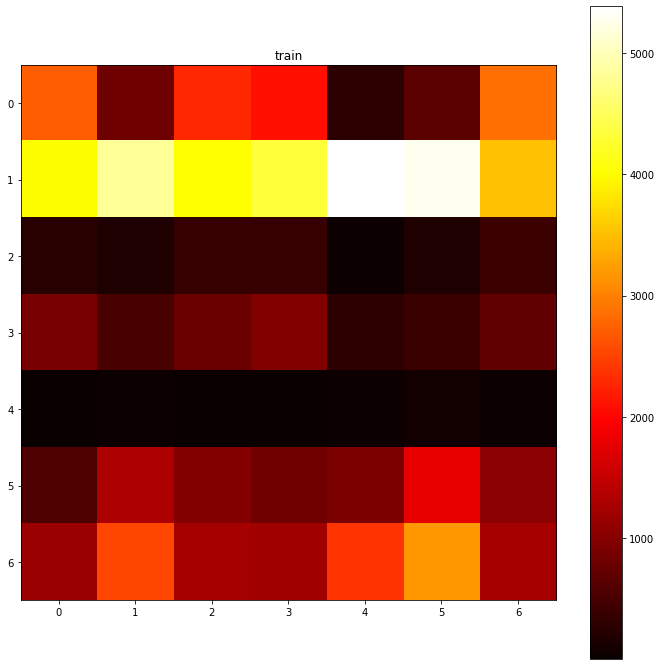

In [ ]:
ClassMatrix=np.zeros((y_prd.shape[-1],y_prd.shape[-1]))
for i in range(y_prd.shape[0]):
  ClassMatrix[np.argmax(y_prd[i]),np.argmax(y_test1_data[i])]+=1
plt.figure(figsize=(12,12))
plt.imshow(ClassMatrix, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('train')
plt.show()

Выводы.
Классификатор всю новую выборку классифицирует в основном как отвращение. Классификатор переобучен на двух типов голосов и не может классифицировать незнакомый голос. Вероятнее всего это связано с высотой звука. Мужской голос ниже женских голосов из первого набора данных, получается что все варианты эмоций мужчины воспринимаются как женщина говорящая с отвращением. Для обучения классификатора, классификации эмоций любого человека нужна другая выборка 100 человек разных возрастов и полов. Классификация в этом случае будет намного сложнее. Нельзя будет привязываться к высоте или тональности звука, нужно будет запоминать откосительные смешения пиков в спектре и относительные временные смещения пиков частоты и громкости. Может помочь Нормализация спектра голоса. т.е. смещение спектров из вссех файлов в один узкий диапазон частот размером 1-1.5 октавы.

Дальше смотреть не нужно это эксперименты.

In [ ]:
song_name='/content/dataverse_files/OAF_jail_disgust.wav'

In [ ]:
HOP_LENGTH=512

In [ ]:
y, sr = librosa.load(song_name, mono=True)#, duration=duration_sec
features = get_features(y, sr)
feature_set = stack_features(features)

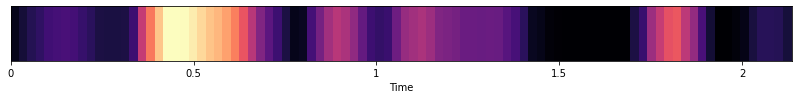

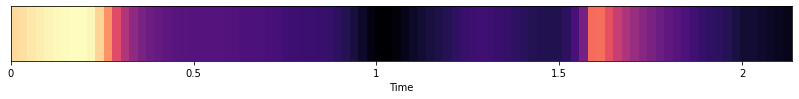

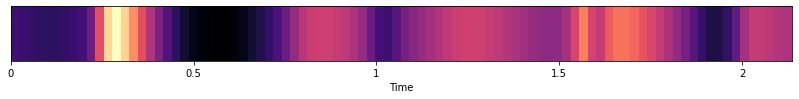

In [ ]:
    # Хромаграмма
chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Мел-кепстральные коэффициенты
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Среднеквадратическая амплитуда
rmse = librosa.feature.rms(y=y, hop_length=HOP_LENGTH)
    # Спектральный центроид
spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Ширина полосы частот
spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Спектральный спад частоты
rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr, n_fft=N_FFT, hop_length=HOP_LENGTH)
    # Пересечения нуля
zcr = librosa.feature.zero_crossing_rate(y, hop_length=HOP_LENGTH)

import librosa.display
# Ваше решение
plt.figure(figsize=(14, 1))
librosa.display.specshow(rmse, sr=sr, x_axis='time')
plt.show()
plt.figure(figsize=(14, 1))
librosa.display.specshow(spec_cent, sr=sr, x_axis='time')
plt.show()
plt.figure(figsize=(14, 1))
librosa.display.specshow(spec_bw, sr=sr, x_axis='time')
plt.show()

In [ ]:
s='OAF_jail_disgust.wav'
s.find('anger')

-1